#DATASCI W261: Machine Learning at Scale

##Version 1: One MapReduce Stage (join data at the first reducer)

# Data Generation

Data Information:
+ Sizes: 1000 points
+ True model: y = 1.0 * x - 4
+ Noise：Normal Distributed mean = 0, var = 5

In [1]:
 %matplotlib inline
import numpy as np
import pylab 
size = 1000
x = np.random.uniform(-40, 40, size)
y = x * 1.0 - 4 + np.random.normal(0,5,size)
data = zip(range(size),y,x)
#data = np.concatenate((y, x), axis=1)
np.savetxt('LinearRegression.csv',data,'%i,%f,%f')

# Data Visualiazation

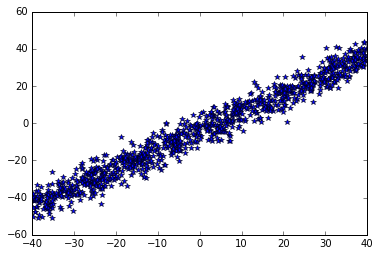

In [2]:
pylab.plot(x, y,'*')
pylab.show()

# MrJob class code

The solution of linear model $$ \textbf{Y} = \textbf{X}\theta $$ is:
$$ \hat{\theta} = (\textbf{X}^T\textbf{X})^{-1}\textbf{X}^T\textbf{y} $$
If $\textbf{X}^T\textbf{X}$ is denoted by $A$, and $\textbf{X}^T\textbf{y}$ is denoted by $b$, then
$$ \hat{\theta} = A^{-1}b $$
There are two MrJob classes to calculate intermediate results:
+ linearRegressionXSquare.py calculates $A = \textbf{X}^T\textbf{X}$
+ linearRegressionXy.py calculates $b = \textbf{X}^T\textbf{y}$

In [3]:
%%writefile linearRegressionXSquare.py
#Version 1: One MapReduce Stage (join data at the first reducer)
from mrjob.job import MRJob

class MRMatrixX2(MRJob):
    #Emit all the data need to caculate cell i,j in result matrix
    def mapper(self, _, line):
        v = line.split(',')
        # add 1s to calculate intercept
        v.append('1.0')
        for i in range(len(v)-2):
            for j in range(len(v)-2):
                yield (j,i),(int(v[0]),float(v[i+2]))
                yield (i,j),(int(v[0]),float(v[i+2]))
                
    # Sum up the product for cell i,j
    def reducer(self, key, values):
        idxdict = {}
        s = 0.0
        preidx = -1
        preval = 0
        f = []
        for idx, value in values:
            if str(idx) in idxdict:
                s = s + value * idxdict[str(idx)]
            else:
                idxdict[str(idx)] = value
        yield key,s

if __name__ == '__main__':
    MRMatrixX2.run()

Writing linearRegressionXSquare.py


In [4]:
%%writefile linearRegressionXy.py
from mrjob.job import MRJob

class MRMatrixXY(MRJob):
    def mapper(self, _, line):
        v = line.split(',')
        # product of y*xi
        for i in range(len(v)-2):
            yield i, float(v[1])*float(v[i+2])
        # To calculate Intercept
        yield i+1, float(v[1])
    
    # Sum up the products
    def reducer(self, key, values):
        yield key,sum(values)

if __name__ == '__main__':
    MRMatrixXY.run()

Writing linearRegressionXy.py


# Driver:

Driver run tow MrJob class to get $\textbf{X}^T\textbf{X}$ and $\textbf{X}^T\textbf{y}$. And it calculate $(\textbf{X}^T\textbf{X})^{-1}$ by numpy.linalg.solve. 

In [5]:
from numpy import linalg,array,empty
from linearRegressionXSquare import MRMatrixX2
from linearRegressionXy import MRMatrixXY
mr_job1 = MRMatrixX2(args=['LinearRegression.csv'])
mr_job2 = MRMatrixXY(args=['LinearRegression.csv'])

X_Square = []
X_Y = []
# Calculate XT*X Covariance Matrix
print "Matrix XT*X:"
with mr_job1.make_runner() as runner: 
    # Run MrJob MatrixMultiplication Job
    runner.run()
    # Extract the output I.E. ship data to driver be careful if data you ship is too big
    for line in runner.stream_output():
        key,value =  mr_job1.parse_output_line(line)
        X_Square.append((key,value ))
        print key, value
print " " 
# Calculate XT*Y
print "Vector XT*Y:"
with mr_job2.make_runner() as runner: 
    runner.run()
    for line in runner.stream_output():
        key,value =  mr_job2.parse_output_line(line)
        X_Y.append((key,value))
        print key, value
print " "    

#Local Processing the output from two MrJob
n = len(X_Y)
if(n*n!=len(X_Square)):
    print 'Error!'
else:
    XX = empty(shape=[n,n])
    for v in X_Square:
        XX[v[0][0],v[0][1]] = v[1]
    XY = empty(shape=[n,1])
    for v in X_Y:
        XY[v[0],0] = v[1]

theta = linalg.solve(XX,XY)
print "Coefficients:",theta[0,0],',',theta[1,0]

Matrix XT*X:
[0, 0] 531195.05005
[0, 1] -207.554094
[1, 0] -207.554094
[1, 1] 1000.0
 
Vector XT*Y:
0 535134.068227
1 -4415.189546
 
Coefficients: 1.00577180615 , -4.20643749
